In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from copy import deepcopy

# constants
DATA_LOC = "/home/ubuntu/projects/datasets/AP_train.txt"

# data formats
FORMAT_ID = "#index"
FORMAT_PAPER_TITLE = "#*"
FORMAT_AUTHORS = "#@"
FORMAT_YEAR = "#t"
FORMAT_VENUE = "#c"
FORMAT_REFERENCES = "#%"
FORMAT_ABSTRACT = "#!"

# data keys
ID = "id"
TITLE = "title"
AUTHOR = "author"
YEAR = "year"
VENUE = "venue"
REFERENCE = "reference"
ABSTRACT = "abstract"

In [2]:
def generatetables():
    main_table = list()
    author_table = list()
    reference_table = list()
    datum = dict()
    with open(DATA_LOC, "r", encoding='utf-8') as file:
        for line in file.readlines():            
            if FORMAT_ID in line:
                # yield already existing datum and continue
                if len(datum.keys()) > 0:
                    main_table.append(datum)
                datum = dict() # re-initialize local datum
                datum[ID] = line.strip(FORMAT_ID).strip()
            elif FORMAT_PAPER_TITLE in line:
                datum[TITLE] = line.strip(FORMAT_PAPER_TITLE).strip()
            elif FORMAT_REFERENCES in line:
                reference_table.append({ID: datum[ID], REFERENCE: line.strip(FORMAT_REFERENCES).strip()})
            elif FORMAT_AUTHORS in line: 
                for author in line.strip(FORMAT_AUTHORS).strip().split(';'):
                    author_table.append({ID: datum[ID], AUTHOR: author.strip()})                    
            elif FORMAT_YEAR in line: 
                datum[YEAR] = line.strip(FORMAT_YEAR).strip()
            elif FORMAT_VENUE in line: 
                datum[VENUE] = line.strip(FORMAT_VENUE).strip()
            elif FORMAT_ABSTRACT in line: 
                datum[ABSTRACT] = line.strip(FORMAT_ABSTRACT).strip()
    return main_table, author_table, reference_table

# generate all tables
main, author, cit = generatetables()


In [3]:
# combine all tables and compute data
main_df = pd.DataFrame(main, columns={ID, TITLE, YEAR, VENUE, ABSTRACT})
author_df = pd.DataFrame(author, columns={ID, AUTHOR})
ref_df = pd.DataFrame(cit, columns={ID, REFERENCE})

consolidated = main_df.merge(author_df, how='outer', on=ID).merge(ref_df, how='outer', on=ID)

print('''
Length of Main DF: {0}\n
Length of Author DF: {1}\n
Length of References DF: {2}\n
Length of Consolidated DF: {3}
'''.format(len(main_df), len(author_df), len(ref_df), len(consolidated)))


Length of Main DF: 1976814

Length of Author DF: 4909851

Length of References DF: 7250328

Length of Consolidated DF: 23565643



### A. Compute the number of distinct authors, publication venues, publications, and citations/references

In [4]:
# distinct authors
print('''
Distinct Authors: {0}\n
Distinct Publication venues: {1}\n
Distinct Publications: {2}\n
Distinct references: {3}
'''.format(
    len(author_df.author.unique()),
    len(main_df.venue.unique()),
    len(main_df.title.unique()),
    len(ref_df.reference.unique())
))


Distinct Authors: 1483293

Distinct Publication venues: 255690

Distinct Publications: 1929486

Distinct references: 871091



### B. Are these numbers likely to be accurate? As an example look up all the publications venue names associated with the conference “Principles and Practice of Knowledge Discovery in Databases”13 – what do you notice?

In [5]:
main_df[main_df.venue.str.contains('Principles and Practice of Knowledge Discovery in Databases')][:5]

,abstract,year,id,title,venue
799595,This paper describes a new research proposal o...,2004,799597,Summarization of dynamic content in web collec...,PKDD '04 Proceedings of the 8th European Confe...
799732,NaN,2004,799734,Proceedings of the 8th European Conference on ...,PKDD '04 Proceedings of the 8th European Confe...
799733,We show how carefully crafted random matrices ...,2004,799735,Random matrices in data analysis,PKDD '04 Proceedings of the 8th European Confe...
799734,There is increasing need to build information ...,2004,799736,Data privacy,PKDD '04 Proceedings of the 8th European Confe...
799735,The next wave in search technology will be dri...,2004,799737,Breaking through the syntax barrier: searching...,PKDD '04 Proceedings of the 8th European Confe...


No, the results are not accurate. As we can see in the results above, the strings have some form of 'year' mentioned in them. So even if the actual venue is not different, the string representation of the venue changes because of the change in the year/date.

### C. For each author, construct the list of publications. Plot a histogram of the number of publications per author (use a logarithmic scale on the y axis)

In [47]:
_pubs, _authors = author_df[author_df.author != ''].sort_values([AUTHOR]).values.T
_keys, _indices = np.unique(_authors, True)
author_pubs = pd.DataFrame({AUTHOR: _keys, 'publications': [list(x) for x in np.split(_pubs, _indices[1:])], 'pub count': [len(list(x)) for x in np.split(_pubs, _indices[1:])]})
author_pubs.sort_values([AUTHOR])[:20]

,author,pub count,publications
0,Fructuoso Amorim,1,[1029805]
1,Xiaofei Liao,1,[1033654]
2,1,1,[405430]
3,3DTotal Team,5,"[1890370, 1778111, 1701008, 1970816, 1614895]"
4,3rd Author,1,[2002464]
5,A. O''Gallagher,2,"[666966, 666963]"
6,A. Tortorici Macaluso,1,[34355]
7,A.O.Demuren,1,[651919]
8,A.Tamilarasi,1,[1315402]
9,AAAI,1,[381854]


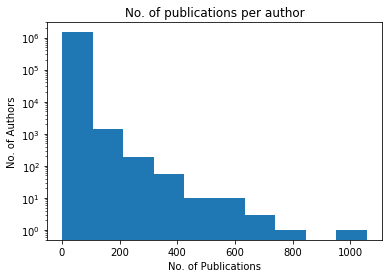

In [59]:
plt.hist(author_pubs['pub count'], log=True)
plt.xlabel('No. of Publications')
plt.ylabel('No. of Authors')
plt.title('No. of publications per author')
plt.show()

### D. Calculate the mean and standard deviation of the number of publications per author. Also calculate the Q1 (1st quartile14), Q2 (2nd quartile, or median) and Q3 (3rd quartile) values.

In [44]:
author_pubs['pub count'].describe()

count    1.483292e+06
mean     3.281670e+00
std      8.836377e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.056000e+03
Name: pub count, dtype: float64

#### Compare the median to the mean and explain the difference between the two values based on the standard deviation and the 1st and 3rd quartiles.

The vast difference between the median and the mean is because the max is very high which skews the mean, but the majority of the authors have 'no. of publications' closes to 1 (the median).

### E. Now plot a histogram of the number of publications per venue..

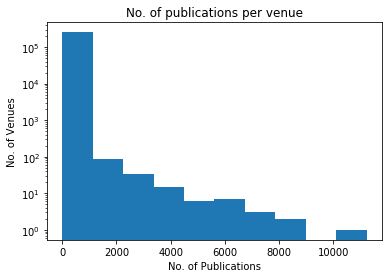

In [65]:
venue_pubs = main_df[main_df[VENUE] != ''].groupby(VENUE)[ID].count().reset_index(name='pub count')
plt.hist(venue_pubs['pub count'], log=True)
plt.xlabel('No. of Publications')
plt.ylabel('No. of Venues')
plt.title('No. of publications per venue')
plt.show()

#### ...as well as calculate the mean, standard deviation, median, Q1, and Q3 values...

In [66]:
venue_pubs['pub count'].describe()

count    255689.000000
mean          7.730841
std          83.380244
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       11227.000000
Name: pub count, dtype: float64

#### ...What is the venue with the largest number of publications in the dataset?

In [68]:
venue_pubs.sort_values(['pub count'], ascending=False)[:1]

,venue,pub count
111545,IEEE Transactions on Information Theory,11227


#### F. Plot a histogram of the number of references (number of publications a publication refers to) and citations (number of publications referring to a publication) per publication. 

In [71]:
publication_cits = ref_df[ref_df[REFERENCE] != ''].groupby([REFERENCE])[ID].count().reset_index(name='cit count')
publication_refs = ref_df.groupby([ID])[REFERENCE].count().reset_index(name='ref count')

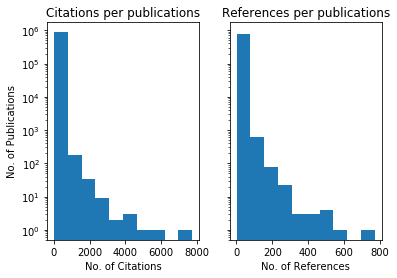

In [82]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(publication_cits['cit count'], log=True)
ax1.set_xlabel('No. of Citations')
ax1.set_ylabel('No. of Publications')
ax1.set_title('Citations per publications')

ax2.hist(publication_refs['ref count'], log=True)
ax2.set_xlabel('No. of References')
ax2.set_title('References per publications')

plt.show()

#### ...What is the publication with the largest number of references?

In [87]:
publication_refs.sort_values(['ref count'], ascending=False)[:5]

,id,ref count
665804,719353,772
110251,1221204,555
322076,1583653,527
195056,1376720,524
110250,1221200,523


#### What is the publication with the largest number of citations?

In [88]:
publication_cits.sort_values(['cit count'], ascending=False)[:5]

,reference,cit count
526606,408396,7753
512286,369236,5891
403026,190581,4748
180759,136350,4399
309887,168251,4336


# Do these make sense?

#### G. Calculate the so called “impact” factor for each venue. To do so, calculate the total number of citations for the publications in the venue, and then divide this number by the number of publications for the venue.

#### Plot a histogram of the results